First hit!

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# 1. Load the dataset
df = pd.read_csv('/Users/owlxshri/Desktop/coral reef/mlpr-project/statisticalinf/g4m copy.csv')

# # 2. Check for missing values
df.dropna(inplace=True)

# # 3. Separate features and target
X = df.drop('Bleaching', axis=1)
y = df['Bleaching'].astype(int)  # ensure target is integer (0/1)

# 4. Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# 5. Reshape for LSTM (samples, timesteps=1, features)
X_reshaped = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# 6. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=42)

# 7. Build LSTM model
model = Sequential([
    LSTM(64, input_shape=(1, X.shape[1]), return_sequences=False),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC()])

# 8. Train
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=50, batch_size=32,
                    validation_split=0.2, callbacks=[early_stop], verbose=1)

# 9. Evaluate
y_pred_proba = model.predict(X_test).ravel()
y_pred = (y_pred_proba > 0.5).astype(int)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print(f"AUC Score: {roc_auc_score(y_test, y_pred_proba):.4f}")


Epoch 1/50


/Users/owlxshri/Desktop/coral reef/.venv/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8102 - auc_2: 0.5786 - loss: 0.5375 - val_accuracy: 0.9238 - val_auc_2: 0.5211 - val_loss: 0.2778
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9342 - auc_2: 0.6707 - loss: 0.2344 - val_accuracy: 0.9238 - val_auc_2: 0.5142 - val_loss: 0.2849
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9405 - auc_2: 0.6005 - loss: 0.2277 - val_accuracy: 0.9238 - val_auc_2: 0.5213 - val_loss: 0.2741
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9398 - auc_2: 0.5210 - loss: 0.2480 - val_accuracy: 0.9238 - val_auc_2: 0.5562 - val_loss: 0.2644
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9497 - auc_2: 0.7596 - loss: 0.1786 - val_accuracy: 0.9286 - val_auc_2: 0.5517 - val_loss: 0.2691
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9527 - auc_2: 0.6960 - loss: 0.1911 - val_accuracy: 0.9286 - val_auc_2: 0.6406 - val_loss: 0.2591
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0

After some performance metrics

Epoch 1/50


/Users/owlxshri/Desktop/coral reef/.venv/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7657 - auc: 0.5832 - loss: 0.5498 - val_accuracy: 0.9238 - val_auc: 0.4879 - val_loss: 0.2781
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9260 - auc: 0.5941 - loss: 0.2734 - val_accuracy: 0.9238 - val_auc: 0.5242 - val_loss: 0.2840
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9418 - auc: 0.5847 - loss: 0.2300 - val_accuracy: 0.9238 - val_auc: 0.5338 - val_loss: 0.2756
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9393 - auc: 0.6444 - loss: 0.2271 - val_accuracy: 0.9238 - val_auc: 0.5424 - val_loss: 0.2659
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9390 - auc: 0.6905 - loss: 0.2130 - val_accuracy: 0.9238 - val_auc: 0.5765 - val_loss: 0.2636
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9354 - auc: 0.6991 - loss: 0.2230 - val_accuracy: 0.9286 - val_auc: 0.6645 - val_loss: 0.2589
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0

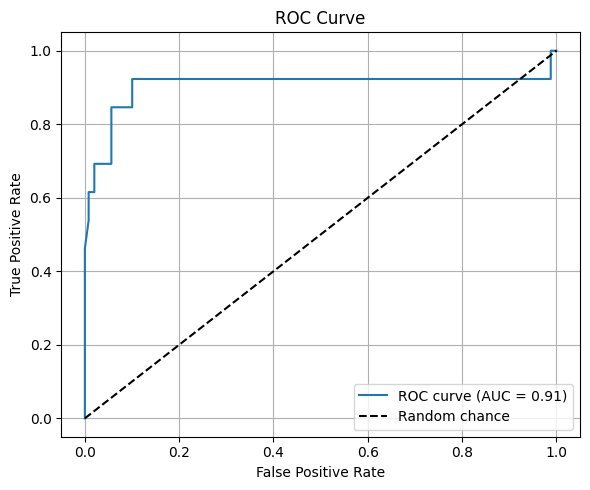

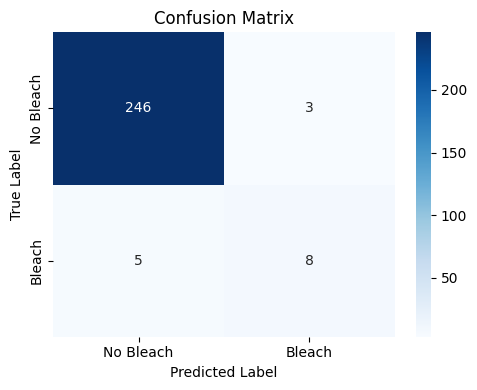

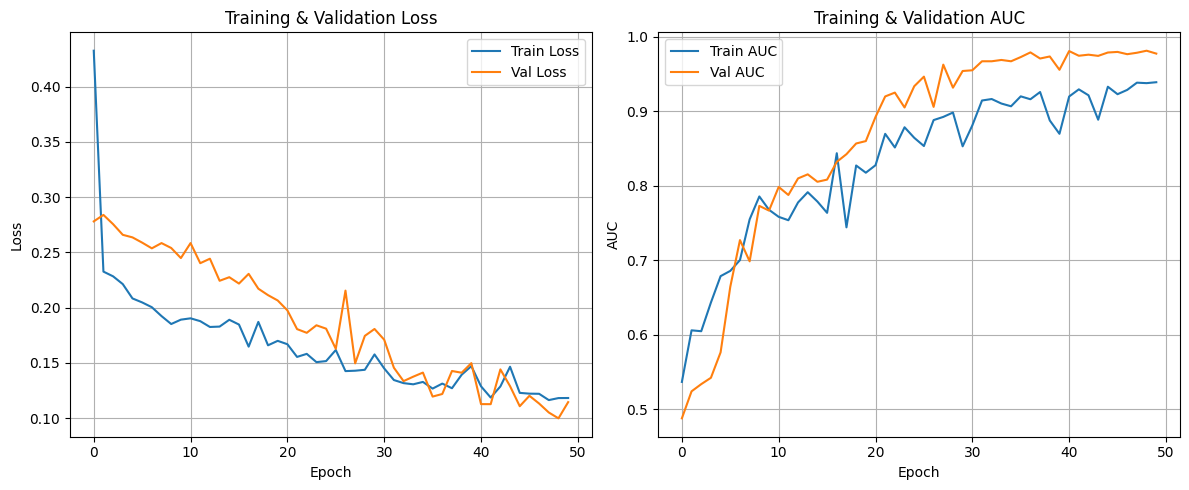

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    roc_curve, fbeta_score
)
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# 1. Load the dataset
df = pd.read_csv('/Users/owlxshri/Desktop/coral reef/mlpr-project/statisticalinf/g4m copy.csv')

# 2. Check for missing values
df.dropna(inplace=True)

# 3. Separate features and target
X = df.drop('Bleaching', axis=1)
y = df['Bleaching'].astype(int)

# 4. Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# 5. Reshape for LSTM (samples, timesteps=1, features)
X_reshaped = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# 6. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_reshaped, y, test_size=0.2, random_state=42
)

# 7. Build LSTM model
model = Sequential([
    LSTM(64, input_shape=(1, X.shape[1]), return_sequences=False),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

# 8. Train model
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    X_train, y_train, epochs=50, batch_size=32,
    validation_split=0.2, callbacks=[early_stop], verbose=1
)

# 9. Evaluate
y_pred_proba = model.predict(X_test).ravel()
y_pred = (y_pred_proba > 0.5).astype(int)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# F2 Score
f2 = fbeta_score(y_test, y_pred, beta=2)
print(f"F2 Score: {f2:.4f}")

print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

print(f"AUC Score: {roc_auc_score(y_test, y_pred_proba):.4f}")

# === Plot 1: ROC Curve ===
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc_score(y_test, y_pred_proba):.2f})")
plt.plot([0, 1], [0, 1], 'k--', label='Random chance')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Plot 2: Confusion Matrix Heatmap ===
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Bleach', 'Bleach'], yticklabels=['No Bleach', 'Bleach'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# === Plot 3: Training History ===
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# AUC
plt.subplot(1, 2, 2)
# Dynamically identify the AUC key
auc_keys = [k for k in history.history if 'auc' in k.lower()]
if auc_keys:
    plt.plot(history.history[auc_keys[0]], label='Train AUC')
    plt.plot(history.history['val_' + auc_keys[0]], label='Val AUC')
    plt.title('Training & Validation AUC')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.legend()
    plt.grid(True)
else:
    print("AUC not found in history. Skipping AUC plot.")

plt.tight_layout()
plt.show()


In [17]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5)
for train_index, val_index in skf.split(X_scaled, y):
    X_train_fold, X_val_fold = X_scaled[train_index], X_scaled[val_index]
    y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]
    # Reshape and train model again...


In [18]:
from sklearn.metrics import precision_recall_curve

prec, rec, thresholds = precision_recall_curve(y_test, y_pred_proba)
f2_scores = [fbeta_score(y_test, y_pred_proba > t, beta=2) for t in thresholds]
best_thresh = thresholds[np.argmax(f2_scores)]


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, fbeta_score
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# 1. Load the dataset
df = pd.read_csv('/Users/owlxshri/Desktop/coral reef/mlpr-project/statisticalinf/g4m copy.csv')
df.dropna(inplace=True)

X = df.drop('Bleaching', axis=1)
y = df['Bleaching'].astype(int)

# 2. Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# 3. K-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold = 1
f2_scores = []
auc_scores = []

for train_idx, val_idx in skf.split(X_scaled, y):
    print(f"\n--- Fold {fold} ---")
    
    # Split the data
    X_train_fold, X_val_fold = X_scaled[train_idx], X_scaled[val_idx]
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]
    
    # Reshape for LSTM
    X_train_fold = X_train_fold.reshape((X_train_fold.shape[0], 1, X_train_fold.shape[1]))
    X_val_fold = X_val_fold.reshape((X_val_fold.shape[0], 1, X_val_fold.shape[1]))
    
    # Build model
    model = Sequential([
        LSTM(64, input_shape=(1, X.shape[1]), return_sequences=False),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(
        X_train_fold, y_train_fold,
        validation_data=(X_val_fold, y_val_fold),
        epochs=50,
        batch_size=32,
        callbacks=[early_stop],
        verbose=0
    )
    
    # Evaluate
    y_val_pred_proba = model.predict(X_val_fold).ravel()
    y_val_pred = (y_val_pred_proba > 0.5).astype(int)
    
    f2 = fbeta_score(y_val_fold, y_val_pred, beta=2)
    auc = roc_auc_score(y_val_fold, y_val_pred_proba)
    
    f2_scores.append(f2)
    auc_scores.append(auc)
    
    print(f"F2 Score: {f2:.4f}")
    print(f"AUC Score: {auc:.4f}")
    print("Classification Report:")
    print(classification_report(y_val_fold, y_val_pred))
    
    fold += 1

print("\n=== Cross-Validation Summary ===")
print(f"Average F2 Score: {np.mean(f2_scores):.4f}")
print(f"Average AUC Score: {np.mean(auc_scores):.4f}")



--- Fold 1 ---


/Users/owlxshri/Desktop/coral reef/.venv/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
F2 Score: 0.4605
AUC Score: 0.9695
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       246
           1       0.58      0.44      0.50        16

    accuracy                           0.95       262
   macro avg       0.77      0.71      0.74       262
weighted avg       0.94      0.95      0.94       262


--- Fold 2 ---


/Users/owlxshri/Desktop/coral reef/.venv/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
F2 Score: 0.2941
AUC Score: 0.9036
Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.98       246
           1       1.00      0.25      0.40        16

    accuracy                           0.95       262
   macro avg       0.98      0.62      0.69       262
weighted avg       0.96      0.95      0.94       262


--- Fold 3 ---


/Users/owlxshri/Desktop/coral reef/.venv/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
F2 Score: 0.6410
AUC Score: 0.9728
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       246
           1       0.71      0.62      0.67        16

    accuracy                           0.96       262
   macro avg       0.85      0.80      0.82       262
weighted avg       0.96      0.96      0.96       262


--- Fold 4 ---


/Users/owlxshri/Desktop/coral reef/.venv/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
F2 Score: 0.2344
AUC Score: 0.9089
Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       246
           1       0.75      0.20      0.32        15

    accuracy                           0.95       261
   macro avg       0.85      0.60      0.64       261
weighted avg       0.94      0.95      0.94       261


--- Fold 5 ---


/Users/owlxshri/Desktop/coral reef/.venv/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
F2 Score: 0.5797
AUC Score: 0.9575
Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       246
           1       0.89      0.53      0.67        15

    accuracy                           0.97       261
   macro avg       0.93      0.76      0.83       261
weighted avg       0.97      0.97      0.97       261


=== Cross-Validation Summary ===
Average F2 Score: 0.4420
Average AUC Score: 0.9425


In [21]:
from sklearn.metrics import precision_recall_curve

# Compute precision, recall, thresholds
prec, rec, thresholds = precision_recall_curve(y_test, y_pred_proba)

# Calculate F2-scores for each threshold
f2_scores = [fbeta_score(y_test, y_pred_proba > t, beta=2) for t in thresholds]

# Best threshold based on maximum F2
best_thresh = thresholds[np.argmax(f2_scores)]
print(f"Best threshold for F2 score: {best_thresh:.4f}")

# Predict using tuned threshold
y_pred_tuned = (y_pred_proba > best_thresh).astype(int)

# Final Evaluation with new threshold
print("\nClassification Report (Tuned Threshold):")
print(classification_report(y_test, y_pred_tuned))

print("Confusion Matrix (Tuned Threshold):")
print(confusion_matrix(y_test, y_pred_tuned))

print(f"F2 Score (Tuned): {fbeta_score(y_test, y_pred_tuned, beta=2):.4f}")
print(f"AUC Score (Same as before): {roc_auc_score(y_test, y_pred_proba):.4f}")


Best threshold for F2 score: 0.1045

Classification Report (Tuned Threshold):
              precision    recall  f1-score   support

           0       0.99      0.94      0.97       249
           1       0.44      0.85      0.58        13

    accuracy                           0.94       262
   macro avg       0.72      0.89      0.77       262
weighted avg       0.96      0.94      0.95       262

Confusion Matrix (Tuned Threshold):
[[235  14]
 [  2  11]]
F2 Score (Tuned): 0.7143
AUC Score (Same as before): 0.9052
